Basin hopping Global Optimisation
=================================

Knowledge 
- https://machinelearningmastery.com/basin-hopping-optimization-in-python/

Basic example with rosenbrock
-----------------------------

In [1]:
from scipy.optimize import rosen, basinhopping
bounds = [(0,2), (0, 2)]
result = basinhopping(rosen, bounds)
result.x, result.fun


(array([0.99999951, 0.99999916, 0.9999985 , 0.99999678]),
 1.351987867340897e-11)

In [2]:
import sys
sys.path.insert(0, '../')
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import basinhopping, Bounds
from scipy.interpolate import interp1d

from silentsub.device import StimulationDevice
from silentsub.plotting import stim_plot
from silentsub.CIE import get_CIES026

sns.set_context('notebook')
sns.set_style('whitegrid')


Load the data with `StimulationDevice`
--------------------------------------

In [3]:
spds = pd.read_csv('../data/S2_corrected_oo_spectra.csv', index_col=['led','intensity'])
spds.index.rename(['Primary', 'Setting'], inplace=True)
spds.columns = pd.Int64Index(spds.columns.astype(int))

# list of colors for the primaries
colors = ['blueviolet', 'royalblue', 'darkblue', 'blue', 'cyan', 
          'green', 'lime', 'orange', 'red', 'darkred']

# instantiate the class
device = StimulationDevice(
    resolutions=[4095]*10,
    colors=colors,
    spds=spds,
    spd_binwidth=1)

Define optimisation problem
---------------------------

This is the 'basic' optimisation where we aim to maximise melanopic contrast whilst keeping cone contrast at zero.

In [4]:
class OptimisationProblem:
    def __init__(self, aopic):
        self.aopic = aopic

    def smlri_calculator(self, weights):
        '''Calculates a-opic irradiance for the given weights.
        The first 10 values in weights define the background
        spectrum and the second 10 values define the modulation'''
        background = weights[0:10]
        modulation = weights[10:20]
        bg_smlri = 0
        mod_smlri = 0
        for led in range(10):
            x = self.aopic.loc[led].index / 4095
            y = self.aopic.loc[led]
            f = interp1d(x, y, axis=0, fill_value='extrapolate')
            bg_smlri += f(background[led])
            mod_smlri += f(modulation[led])
        return (pd.Series(bg_smlri, index=self.aopic.columns, name='Background'),
                pd.Series(mod_smlri, index=self.aopic.columns, name='Modulation'))

    def objective_function(self, weights):
        '''Calculates negative melanopsin contrast for background
        and modulation spectra. We want to minimise this.'''
        bg_smlri, mod_smlri = self.smlri_calculator(weights)
        contrast = (mod_smlri.I-bg_smlri.I) / bg_smlri.I
        return -contrast

    def cone_contrast_constraint_function(self, weights):
        '''Calculates S-, M-, and L-opic contrast for background
        and modulation spectra. We want to this to be zero'''
        bg_smlri, mod_smlri = self.smlri_calculator(weights)
        contrast = np.array([(mod_smlri.S-bg_smlri.S) / bg_smlri.S,
                             (mod_smlri.M-bg_smlri.M) / bg_smlri.M,
                             (mod_smlri.L-bg_smlri.L) / bg_smlri.L])
        return contrast

    def weights_to_settings(self, weights):
        '''Turns weights to 12-bit STLAB settings.'''
        return ([int(val*4095) for val in weights[0:10]],
                [int(val*4095) for val in weights[10:20]])

Do optimisation
---------------

basinhopping step 0: f -0.953424
Melanopsin contrast at minimum: -0.953424015199657, accepted True


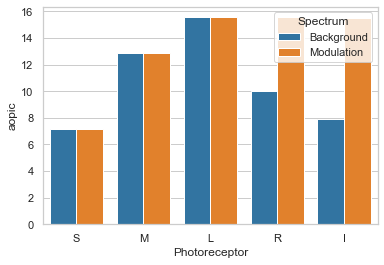

[  9.81934315e-01   2.67110021e-01   2.42512697e-14   3.41621199e-16
   3.35365457e-15   3.46941586e-02   7.90248515e-01   1.47007317e-02
   1.51412560e-06   5.28160935e-01   8.38092163e-15   1.07007328e-01
   7.93200625e-02   8.57156121e-01   9.94241597e-01   6.88186775e-16
   5.73005188e-16   3.91019439e-01   9.58460670e-01   4.28266510e-01]
basinhopping step 1: f -1.09278 trial_f -1.09278 accepted 1  lowest_f -1.09278
found new global minimum on step 1 with function value -1.09278
Melanopsin contrast at minimum: -1.0927768248586027, accepted True


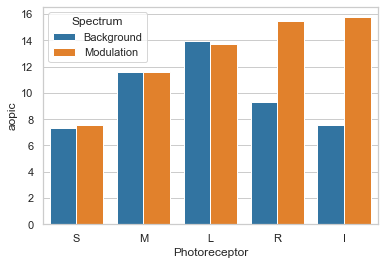

[  9.99753357e-01   3.01587296e-01   8.22471013e-16   2.96640700e-16
   2.17827827e-16   9.83084420e-03   7.10777546e-01   5.53549589e-04
   2.69466328e-16   4.25599131e-01   1.27630062e-17   9.79774125e-02
   6.56902069e-02   9.95762128e-01   9.52514628e-01   9.77437427e-17
   3.32853796e-17   2.38740763e-01   9.45633066e-01   1.00000000e+00]
basinhopping step 2: f -1.50176 trial_f -1.50176 accepted 1  lowest_f -1.50176
found new global minimum on step 2 with function value -1.50176
Melanopsin contrast at minimum: -1.5017592106937403, accepted True


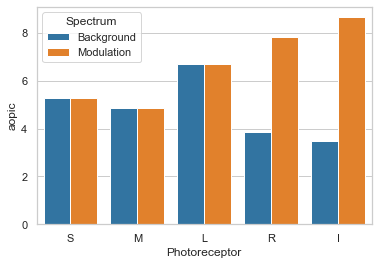

[  7.46031761e-01   1.90535437e-01   1.99806285e-12   5.84982997e-14
   2.40585965e-14   1.00768271e-11   1.71491356e-01   2.34064076e-01
   4.19981446e-14   1.65980374e-14   8.53853583e-08   7.97965999e-14
   2.33884763e-01   6.65288351e-01   1.91648684e-01   3.43037793e-13
   8.09597927e-14   4.36274999e-02   9.93643773e-01   1.00000000e+00]
basinhopping step 3: f -1.7898 trial_f -1.7898 accepted 1  lowest_f -1.7898
found new global minimum on step 3 with function value -1.7898
Melanopsin contrast at minimum: -1.7897950150843345, accepted True


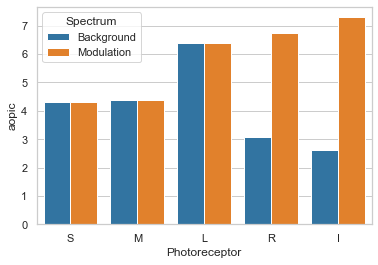

[  8.72834234e-01   3.86263350e-16   5.75735227e-16   2.55714620e-16
   3.16274656e-16   5.88681774e-15   1.43561188e-01   2.49123222e-01
   0.00000000e+00   1.16524760e-15   9.83969883e-03   4.79302857e-02
   9.23015881e-04   6.76943671e-01   2.05095264e-01   2.50999717e-15
   1.32016572e-15   4.81733951e-02   9.18456636e-01   1.00000000e+00]
basinhopping step 4: f -0.765302 trial_f -0.765302 accepted 1  lowest_f -1.7898
Melanopsin contrast at minimum: -0.7653017285525621, accepted True


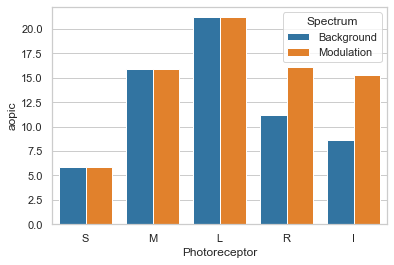

[  6.50735039e-01   2.37171608e-01   1.56219672e-04   3.79217416e-03
   1.59847507e-02   8.14975527e-01   1.50846174e-01   8.03365306e-01
   1.23819144e-15   6.00771677e-16   9.51658457e-17   1.30998727e-16
   2.19171469e-16   9.09066067e-01   1.00000000e+00   1.89685839e-15
   1.06538367e-01   5.77907603e-01   1.00000000e+00   1.00000000e+00]
basinhopping step 5: f -2.08914 trial_f -2.08914 accepted 1  lowest_f -2.08914
found new global minimum on step 5 with function value -2.08914
Melanopsin contrast at minimum: -2.0891403011627405, accepted True


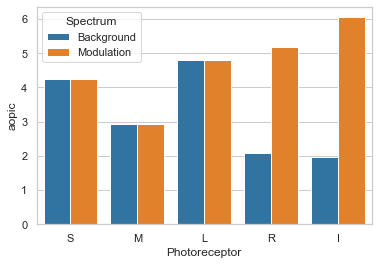

[  8.58289348e-01   0.00000000e+00   7.03606606e-15   0.00000000e+00
   0.00000000e+00   3.23605288e-02   3.44601016e-02   2.69968656e-01
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   3.66147014e-02   7.63224882e-01   1.91241365e-03   0.00000000e+00
   0.00000000e+00   4.76157547e-02   6.21915800e-01   1.00000000e+00]
basinhopping step 6: f -5.11192 trial_f -5.11192 accepted 1  lowest_f -5.11192
found new global minimum on step 6 with function value -5.11192
Melanopsin contrast at minimum: -5.1119155037135995, accepted True


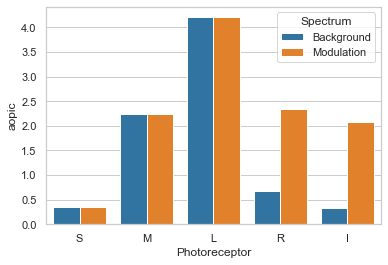

[  5.37505409e-02   3.06900189e-12   1.60711338e-12   7.48524377e-13
   2.58028452e-12   6.76655324e-12   2.52157676e-09   2.76628258e-01
   1.57032941e-02   5.36115334e-03   5.97724358e-10   1.19530550e-11
   9.57986920e-10   8.89191566e-12   2.15479789e-01   1.11207193e-08
   2.43130060e-11   1.07303640e-11   5.03486209e-01   9.51937049e-01]


In [18]:
# A random starting point for the optimisation
x0 = np.random.rand(1, 20)[0]

op = OptimisationProblem(device.aopic)

constraints = ({
    'type': 'eq',
    'fun': lambda x: op.cone_contrast_constraint_function(x)
})

# The bounds should be between 0-1, otherwise we are outside the
# gamut of the device
bounds = [(0, 1.),] * 20

# Plotting func for call back
def plot_solution(background, modulation):
    df = (
        pd.concat([background, modulation], axis=1)
        .T.melt(
            value_name='aopic',
            var_name='Photoreceptor',
            ignore_index=False)
        .reset_index()
        .rename(
            columns={'index': 'Spectrum'})
         )
    fig = sns.barplot(data=df, x='Photoreceptor', y='aopic', hue='Spectrum')
    plt.show()

# List to store valid solutions
minima = []

def print_fun(x, f, accepted):
    print(f"Melanopsin contrast at minimum: {f}, accepted {accepted}")
    bg, mod = op.smlri_calculator(x)
    plot_solution(bg, mod)
    print(x)
    if accepted:
        minima.append(x)
        if f < -4. and accepted: # the target is 400% contrast
            return True
        
minimizer_kwargs = {
    'method': 'SLSQP',
    'bounds': bounds,
    'options': {'maxiter': 100},
    'constraints': constraints
}
    
# Do basinhopping
res = basinhopping(
    func=op.objective_function,
    x0=x0,
    niter=100,
    T=1.0,
    stepsize=0.5,
    minimizer_kwargs=minimizer_kwargs,
    take_step=None,
    accept_test=None,
    callback=print_fun,
    interval=50,
    disp=True,
    niter_success=None,
    seed=None,
)